In [1]:
from mg_utils import *

# Drift Equilibrium
Fixed: β, r

Eq: V, δ, Fx

In [2]:
# parameters and initial conditions
# FORCE_REAR = 30 # [N] constant rear longitudinal force per wheel
# STEER = 0.35 # [rad] constant steering angle
# DELTA, FX = STEER * steering_ratio_f, 2 * FORCE_REAR # wheel angle and longitudinal force

DELTA, FX = -15*π/180, 20 # wheel angle and longitudinal force
V0, BETA0, R0 = 4, -25*π/180, 1.2 # [m/s], [rad], [rad/s] initial velocity, sideslip angle, and yaw rate
# V0, BETA0, R0 = 4, -25*π/180, 0.5 # [m/s], [rad], [rad/s] initial velocity, sideslip angle, and yaw rate
# V0, BETA0, R0 = 4, 5*π/180, 1 # [m/s], [rad], [rad/s] initial velocity, sideslip angle, and yaw rate

T = 4 # [s] total simulation time
DT = 0.001 # [s] time step for the simulation
N_STEPS = int(T / DT) # number of steps in the simulation


print(f'Max Force: {μr * Fz_Rear :.2f} [N]')

Max Force: 46.11 [N]


Initial state: [+4.000000 -0.436332 +1.200000] [v,β,r]
Final state:   [+0.949263 +0.957119 +2.799541] [v,β,r]


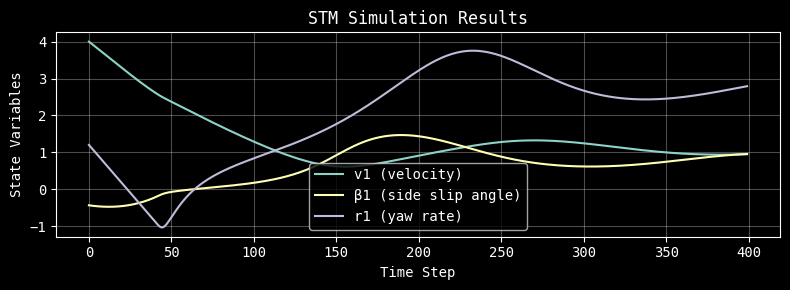

In [3]:
# equation of motion for the Single Track Model
def d_vβr(vβr, δ, Fx): 
    v, β, r = vβr # unpack the state vector
    # assert v >= 0, "Velocity must be non-negative" # ensure velocity is non-negative
    if v < 0.001: v = 0.001 # avoid division by zero
    Fyf = tire(f_αf(δ,v,β,r), 0.0, Fz_Front, μf, Cyf) # lateral force front
    Fyr = tire(f_αr(δ,v,β,r), Fx, Fz_Rear, μr, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force
    return np.array([ # equations of motion
        (-Fyf*np.sin(δ-β) + Fxr*np.cos(β) + Fyr*np.sin(β)) / m, # V dot
        (+Fyf*np.cos(δ-β) - Fxr*np.sin(β) + Fyr*np.cos(β)) / (m*v) - r, # β dot
        (a*Fyf*np.cos(δ) - b*Fyr) / J_CoG # r dot
    ])

def stm_rk4(vβr, δ, Fx, dt=DT): # runge-kutta 4th order method
    k1 = d_vβr(vβr, δ, Fx) * dt
    k2 = d_vβr(vβr + k1/2, δ, Fx) * dt
    k3 = d_vβr(vβr + k2/2, δ, Fx) * dt
    k4 = d_vβr(vβr + k3, δ, Fx) * dt
    return vβr + (k1 + 2*k2 + 2*k3 + k4) / 6 # update the state vector

# initialize the state vector
state = np.zeros((N_STEPS, 3)) # [u, v, r]
state[0] = np.array([V0, BETA0, R0]) # initial state in v,β,r format
print(f"Initial state: {state[0]} [v,β,r]") # print the initial state in v,β,r format

# initialize the u input vector
u = np.zeros((N_STEPS, 2)) # [δ, Fx]
u[:,0], u[:,1] = FX, DELTA # assign constant values
# run the simulation
for i in range(1, N_STEPS):
    state[i] = stm_rk4(state[i-1], u[i, 0], u[i, 1])  
print(f"Final state:   {state[-1]} [v,β,r]") # print the final state in v,β,r format

# plot first n steps of the simulation  
dec = 10 # decimation factor
v1, β1, r1 = state[:,0], state[:,1], state[:,2] # unpack the state vector
v1, β1, r1 = v1[::dec], β1[::dec], r1[::dec] # decimate the state vector
plt.figure(figsize=(8, 3))
plt.plot(v1, label='v1 (velocity)')
plt.plot(β1, label='β1 (side slip angle)')
plt.plot(r1, label='r1 (yaw rate)')
plt.title('STM Simulation Results')
plt.xlabel('Time Step')
plt.ylabel('State Variables')
plt.legend()
plt.tight_layout()
plt.show()



In [4]:
# # car animation
# anim = car_anim(
#     xs=state,  # use the state vector as input
#     us=u,  # use the u input vector for steering angles
#     ic=np.array([0, 0,π/2]),  # initial conditions (x, y, ψ) 
#     dt=DT,  # time step
#     fps=60,  # frames per second
#     speed=1.0  # speed factor for the animation
# )  # run the car animation with the STM results

In [ ]:
# same as before, but using casadi for symbolic differentiation
import casadi as ca
from casadi import SX, sqrt, atan, tan, sin, cos, tanh, atan2, fabs, vertcat, if_else, sign
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver, AcadosSim, AcadosSimSolver
# suppress warnings acados
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='acados_template')

# variables
v = SX.sym('v') # velocity
# v̇ = SX.sym('v̇') # velocity dot
β = SX.sym('β') # sideslip angle
# β̇ = SX.sym('β̇') # sideslip angle dot
r = SX.sym('r') # yaw rate
# ṙ = SX.sym('ṙ') # yaw rate dot
δ = SX.sym('δ') # wheel angle (on the road)
Fx = SX.sym('Fx') # rear longitudinal force

x = vertcat(v, β, r) # state vector
# ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
u = vertcat(δ, Fx) # u input vector 

# tire model
αf = δ - atan2(v*sin(β) + a*r, v*cos(β))
αr = -atan2(v*sin(β) - b*r, v*cos(β))
def fiala_tanh_ca(α, Fx, Fz, μ, Cy):
    Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    αs = atan(Fy_max/Cy) # maximum slip angle
    return Fy_max * tanh(α / αs) # tanh approximation
def fiala_ca(α, Fx, Fz, μ, Cy):
    Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    Fy_lin = Cy * tan(α) - Cy**2 * fabs(tan(α)) * tan(α) / (3 * Fy_max) + Cy**3 * tan(α)**3 / (27 * Fy_max**2)
    Fy_sat = Fy_max * sign(α)
    return if_else(fabs(α) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

# choose the tire model
# def tire(α, Fx, Fz, μ, Cy): return fiala_tanh_ca(α, Fx, Fz, μ, Cy) # choose the tire model
def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

# lateral forces
Fyf = tire(αf, 0.0, Fz_Front, μf, Cyf) # lateral force front
Fyr = tire(αr, Fx, Fz_Rear, μr, Cyr) # lateral force rear
Fxr = Fx # rear longitudinal force

# define the symbolic equations of motion
dv = (-Fyf*sin(δ-β) + Fxr*cos(β) + Fyr*sin(β)) / m # V dot
dβ = (+Fyf*cos(δ-β) - Fxr*sin(β) + Fyr*cos(β)) / (m*v) - r # β dot
dr = (a*Fyf*cos(δ) - b*Fyr) / J_CoG # r dot

dx = vertcat(dv, dβ, dr) # equations of motion

# create the model
model = AcadosModel()
model.name='stm_model'
# model.f_impl_expr = ẋ - dx  
model.f_expl_expr = dx 
model.x = x  # state vector
# model.xdot = ẋ  # state dot vector
model.u = u  # u input vector

In [6]:
# test Acados Integrator
sim1step = AcadosSim()
sim1step.model = model  # set the model
sim1step.solver_options.T = DT  # 
sim1step.solver_options.integrator_type = 'ERK'
acados_integrator = AcadosSimSolver(sim1step)  # create the integrator

# test the integrator
xs = np.zeros((N_STEPS, 3)) # [v, β, r]
xs[0] = np.array([V0, BETA0, R0]) # initial state in v,β,r format
us = np.zeros((N_STEPS, 2)) # [δ, Fx]
us[:,0], us[:,1] = FX, DELTA # assign constant values
for i in range(1, N_STEPS):
    xs[i] = acados_integrator.simulate(x=xs[i-1], u=us[i-1])  # simulate one step

# # car animation
# anim = car_anim(
#     xs=xs,  # use the state vector as input
#     us=us,  # use the u input vector for steering angles
#     ic=np.array([0, 0,π/2]),  # initial conditions (x, y, ψ) 
#     dt=DT,  # time step
#     fps=60,  # frames per second
#     speed=0.5 # speed factor for the animation
# )  # run the car animation with the STM results

print(f"Final state:   {xs[-1]} [v,β,r]") # print the final state in v,β,r format

Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
cc -fPIC -std=c99   -O2 -I/home/mg/repos/acados/include -I/home/mg/repos/acados/include/acados -I/home/mg/repos/acados/include/blasfeo/include -I/home/mg/repos/acados/include/hpipm/include  -c -o acados_sim_solver_stm_model.o acados_sim_solver_stm_model.c
cc -fPIC -std=c99   -O2 -I/ho

## Finding equilibrium point with Casadi
Fixed: β, r

Optim: V, δ, Fx

In [7]:
#constraints
print(f'Constraints: MAX_DELTA={MAX_DELTA:.2f}, MAX_V={MAX_V:.2f}, MIN_V={MIN_V:.2f}, MAX_FX={MAX_FX:.2f}, MIN_FX={MIN_FX:.2f}')

Constraints: MAX_DELTA=0.44, MAX_V=10.00, MIN_V=0.50, MAX_FX=30.00, MIN_FX=0.00


In [8]:
# Define optimization problem to find steady-state (dx == 0)
def find_eq(fix_β, fix_radius, verbose=False, ret_error=False):
    f = dx  # equations of motion
    opt_vars = vertcat(v, β, r, δ, Fx)  # optimization variables
    opt_func = ca.Function('opt_func', [opt_vars], [f])  # create a function for the equations of motion
    g = vertcat(δ,Fx,v,fabs(v/r),fabs(r),β) # constraints: δ, Fx, v, v/r, |r|, β
    ubg = vertcat(MAX_DELTA, MAX_FX, MAX_V, fix_radius, ca.inf, fix_β)  # upper bounds 
    lbg = vertcat(-MAX_DELTA, MIN_FX, MIN_V, fix_radius, 0, fix_β)  # lower bounds
    
    nlp = { # NLP -> minimize sum of squares of residuals
        'x': opt_vars, # optimization variables
        'f': ca.sumsqr(opt_func(opt_vars)), # objective function (sum of squares of residuals)
        'g': g
    }  

    # nlp = { # maximize drift
    #     'x': opt_vars, # optimization variables
    #     'f': ca.sumsqr(opt_func(opt_vars)) + (β+δ)**2, # objective function (sum of squares of residuals)
    #     'g': g
    # } 

    # nlp = { # minimize drift
    #     'x': opt_vars, # optimization variables
    #     'f': ca.sumsqr(opt_func(opt_vars)) - (β+δ)**2, # objective function (sum of squares of residuals)
    #     'g': g
    # } 

    opts = {} if verbose else {'ipopt.print_level':0, 'print_time':0}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts) # solver for the NLP
    # initial_guess = [MAX_V, fix_β, MAX_V/fix_radius, MAX_FX, -MAX_DELTA]  # <- initial guess for the optimization variables
    # initial_guess = [MAX_V, fix_β, MAX_V/fix_radius, MIN_FX, 0]  # initial guess for the optimization variables
    # initial_guess = [MAX_V/2, fix_β, MAX_V/fix_radius, MAX_FX/2, -MAX_DELTA/2]  # initial guess for the optimization variables
    initial_guess = [1e-3, fix_β, MAX_V/fix_radius, 1e-3, 0]  # initial guess for the optimization variables
    # initial_guess = [1e-3, fix_β, 1e-3, 1e-3, 0]  # initial guess for the optimization variables
    sol = solver(x0=initial_guess, lbg=lbg, ubg=ubg)  # solve the NLP with constraints

    error = np.array(opt_func(sol["f"])).reshape(-1)

    # simulate the STM with the solution
    # create the vector of initial conditions
    eq_x = [float(sol["x"][0]), float(sol["x"][1]), float(sol["x"][2])]  # use the solution for v, keep β and r fixed
    eq_u = [float(sol["x"][3]), float(sol["x"][4])]  # use the solution for δ and Fx

    if ret_error: return eq_x, eq_u, error
    else: return eq_x, eq_u  # return the equilibrium point

eq_x, eq_u = find_eq(fix_β=BETA0, fix_radius=3.0)  # find the equilibrium point with fixed β and r
print(f'Equilibrium point: v={eq_x[0]:.2f}, β={eq_x[1]*180/π:.2f}, r={eq_x[2]:.2f}, δ={eq_u[0]*180/π:.2f}, Fx={eq_u[1]:.2f}')  # print the equilibrium point
print(f'x_eq, u_eq = {eq_x}, {eq_u}')  # print the equilibrium point

xs = sim_stm_fixed_u(
    vβr0=eq_x,  # use the equilibrium point as initial state
    δ=eq_u[0],  # use the solution for δ
    Fx=eq_u[1],  # use the solution for Fx
    sim_t=0.5,  # simulate for 2 seconds
    dt=DT,  # time step
    verbose=True,  # print the initial state
)  # run the simulation with the equilibrium point



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Equilibrium point: v=3.61, β=-25.00, r=1.20, δ=-10.79, Fx=27.48
x_eq, u_eq = [3.610849747542315, -0.4363323129985824, 1.2036165825141052], [-0.18825862766328222, 27.47665205296075]
Initial state: [+3.610850 -0.436332 +1.203617] [v,β,r], δ=-0.19, Fx=27.48
Final state:   [+3.610850 -0.436332 +1.203617] [v,β,r]


In [9]:
# simulate the STM with the solution
#let's do a perfect circle
r_turn = np.abs(eq_x[0]/eq_x[2])  # radius of the turn
print(f'Radius of the turn: {r_turn:.2f} [m]')
full_circle = 2*π*r_turn  # full circle length
sim_time = full_circle / eq_x[0]  # time to complete a full circle
print(f'Time to complete a full circle: {sim_time:.2f} [s]')
 
xs = sim_stm_fixed_u(
    vβr0=eq_x,  # use the equilibrium point as initial state
    δ=eq_u[0],  # use the solution for δ
    Fx=eq_u[1],  # use the solution for Fx
    sim_t=sim_time,  # simulate for 2 seconds
    dt=DT,  # time step
    verbose=True,  # suppress output
)  # run the simulation with the equilibrium pointss
 
# animation
anim = car_anim(
    xs=xs,  # use the state vector as input 
    us=np.ones((xs.shape[0],2)) * eq_u,  # use the solution for Fx and δ
    ic=np.array([0, 0, np.pi/2]),  # initial conditions (x, y, ψ) 
    dt=DT,  # time step
    fps=60,  # frames per second
    speed=0.75,  # speed factor for the animation
    # follow=True,  # follow the car in the animation
)  # run the car animation with the STM results

Radius of the turn: 3.00 [m]
Time to complete a full circle: 5.22 [s]
Initial state: [+3.610850 -0.436332 +1.203617] [v,β,r], δ=-0.19, Fx=27.48
Final state:   [+3.692030 -0.389136 +0.970143] [v,β,r]


In [10]:
# explore the equilibrium space
n_grid = 30
# βs, radii = np.linspace(-30*π/180, -8*π/180, n_grid),  np.linspace(2, 10, n_grid)   # [rad], [m]
βs, radii = np.linspace(-30*π/180, -1*π/180, n_grid),  np.linspace(1, 8, n_grid)   # [rad], [m]

# create a meshgrid for the sideslip angles and radiis
β_grid, radius_grid = np.meshgrid(βs, radii)  # create
gg = np.stack([β_grid, radius_grid], axis=-1).reshape(-1,2)  # stack the sideslip angles and radii

gx, gu, gerr = np.zeros((gg.shape[0], 3)), np.zeros((gg.shape[0], 2)), np.zeros((gg.shape[0], 3)) # init
eq_divs = np.zeros((gg.shape[0],3)) # eq divergence
for i, (f_β, f_rad) in enumerate(tqdm(gg)):  # iterate over the sideslip angles and radii
    gx[i], gu[i], gerr[i] = find_eq(fix_β=f_β, fix_radius=f_rad, ret_error=True)  # find the equilibrium point
    xs = sim_stm_fixed_u(vβr0=gx[i], δ=gu[i,0], Fx=gu[i,1], sim_t=50*DT, dt=DT) 
    eq_divs[i] = np.abs(xs[0]-xs[-1])

100%|██████████| 900/900 [00:14<00:00, 60.21it/s]


Found 88 NaNs, 0 Infs, and 0 points with error > 1e-3
Keeping 900 out of 900 equilibrium points
err: nan - nan [N]
err: nan [N]


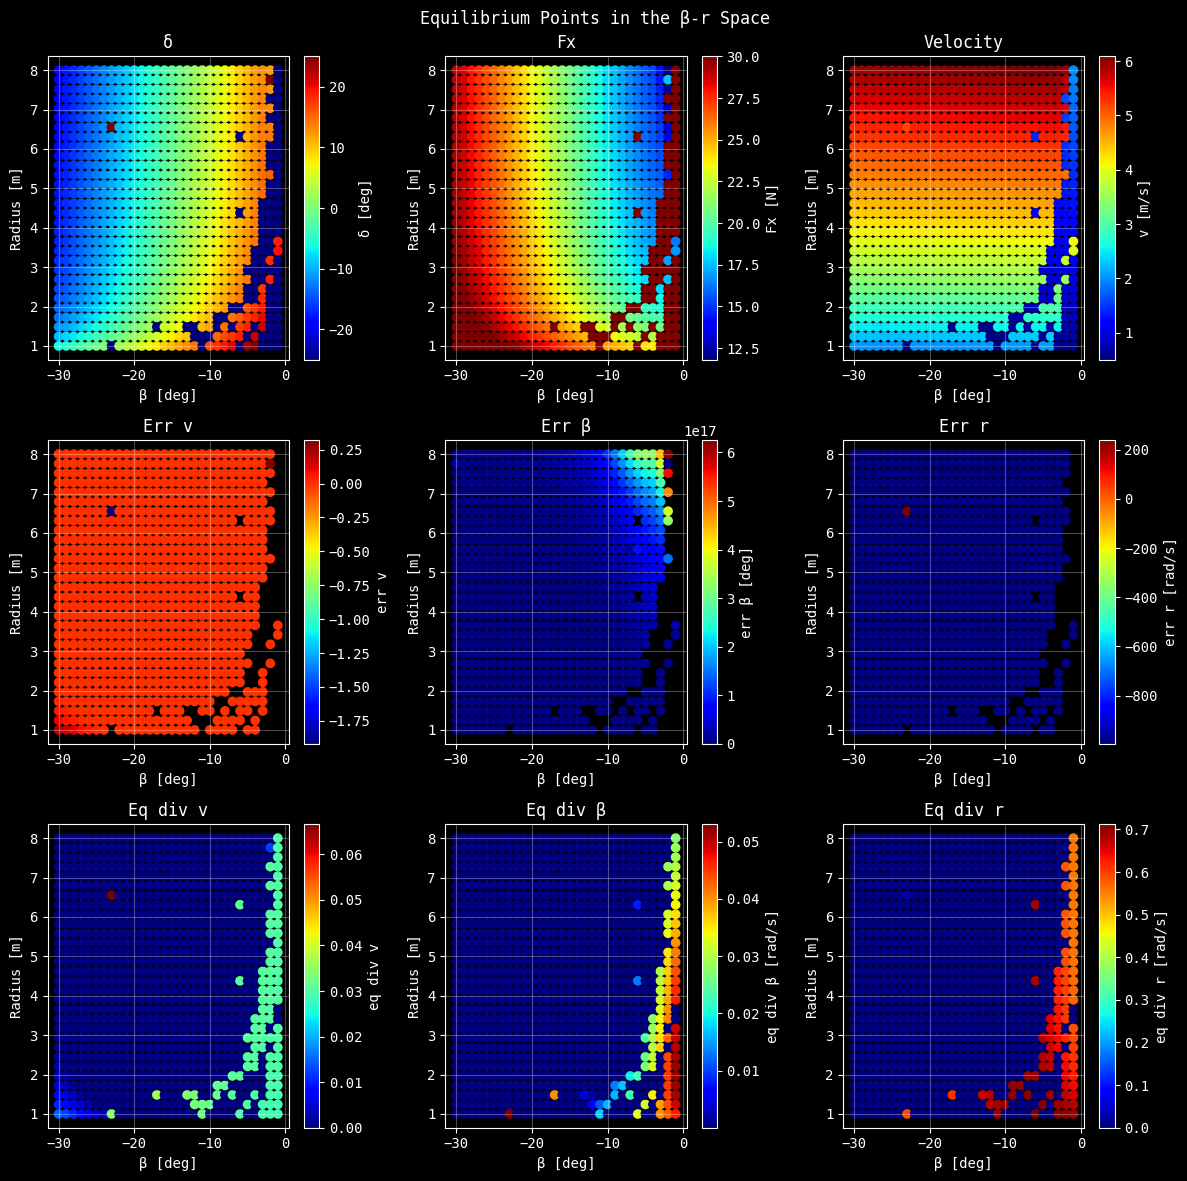

In [11]:
# plot the equilibrium points space
err = np.linalg.norm(gerr, axis=-1)  # compute the error norm

nan_idxs = np.isnan(err)  # find nans in the error norm
inf_idxs = np.isinf(err)  # find infs in the error norm
thrsh_idxs = err > np.inf  # find indices where the error norm is greater than 1e-3

print(f'Found {nan_idxs.sum()} NaNs, {inf_idxs.sum()} Infs, and {thrsh_idxs.sum()} points with error > 1e-3')  # print the number of invalid equilibrium points

# to_keep = ~(nan_idxs | inf_idxs | thrsh_idxs)  # keep only the valid indices
to_keep = np.ones_like(err, dtype=bool)  # keep all indices for now
print(f'Keeping {to_keep.sum()} out of {to_keep.size} equilibrium points')  # print the number of valid equilibrium points

print(f'err: {err.min():.2e} - {err.max():.2e} [N]')  # print the error norm
print(f'err: {np.mean(err):.2e} [N]')

# filter the equilibrium points
ggf = gg[to_keep]  # filter the sideslip angles and radii
gxf = gx[to_keep]  # filter the equilibrium points
guf = gu[to_keep]  # filter the u inputs
gerrf = gerr[to_keep]  # filter the error
errf = err[to_keep]  # filter the error norm
eq_divsf = eq_divs[to_keep]  # filter the equilibrium divergence

# reshape back to grid
ggf = ggf.reshape(n_grid, n_grid, 2)  # reshape the sideslip angles and radii
gxf = gxf.reshape(n_grid, n_grid, 3)  # reshape the equilibrium points
guf = guf.reshape(n_grid, n_grid, 2)  # reshape the u inputs
gerrf = gerrf.reshape(n_grid, n_grid, 3)  # reshape the error
errf = errf.reshape(n_grid, n_grid)  # reshape the error norm
eq_divsf = eq_divsf.reshape(n_grid, n_grid, 3)  # reshape the equilibrium divergence

# plot the equilibrium points
plt.figure(figsize=(12, 12))
lev = 20

plt.subplot(3, 3, 1)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=guf[...,0]*180/π)
# plt.contour(ggf[...,0]*180/π, ggf[...,1], guf[...,0]*180/π, levels=lev)
plt.colorbar(label='δ [deg]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('δ')

plt.subplot(3, 3, 2)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=guf[...,1])
# plt.contour(ggf[...,0]*180/π, ggf[...,1], guf[...,1], levels=lev)
plt.colorbar(label='Fx [N]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Fx')

plt.subplot(3, 3, 3)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=gxf[...,0])
# plt.contour(ggf[...,0]*180/π, ggf[...,1], gxf[...,0], levels=lev)
plt.colorbar(label='v [m/s]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Velocity')

plt.subplot(3, 3, 4) #gerr 0
plt.scatter(ggf[...,0]*180/π, np.abs(ggf[...,1]), c=gerrf[...,0])
# plt.contour(ggf[...,0]*180/π, np.abs(ggf[...,1]), gerrf[...,0], levels=lev)
plt.colorbar(label='err v')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Err v')

plt.subplot(3, 3, 5) #gerr 1
plt.scatter(ggf[...,0]*180/π, np.abs(ggf[...,1]), c=gerrf[...,1]*180/π)
# plt.contour(ggf[...,0]*180/π, ggf[...,1], gerrf[...,1]*180/π, levels=lev)
plt.colorbar(label='err β [deg]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Err β')

plt.subplot(3, 3, 6) #gerr 2
plt.scatter(ggf[...,0]*180/π, np.abs(ggf[...,1]), c=gerrf[...,2]*180/π)
# plt.contour(ggf[...,0]*180/π, ggf[...,1], gerrf[...,2]*180/π, levels=lev)
plt.colorbar(label='err r [rad/s]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Err r')

plt.subplot(3, 3, 7)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=eq_divsf[...,0])
# plt.contour(ggf[...,0]*180/π, ggf[...,1], eq_divsf[...,0], levels=lev)
plt.colorbar(label='eq div v')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Eq div v')   

plt.subplot(3, 3, 8)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=eq_divsf[...,1])
# plt.contour(ggf[...,0]*180/π, ggf[...,1], eq_divsf[...,1], levels=lev)
plt.colorbar(label='eq div β [rad/s]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Eq div β')

plt.subplot(3, 3, 9)
plt.scatter(ggf[...,0]*180/π, ggf[...,1], c=eq_divsf[...,2])
# plt.contour(ggf[...,0]*180/π, ggf[...,1], eq_divsf[...,2], levels=lev)
plt.colorbar(label='eq div r [rad/s]')
plt.xlabel('β [deg]'), plt.ylabel('Radius [m]')
plt.title('Eq div r')

plt.suptitle('Equilibrium Points in the β-r Space')
plt.tight_layout()
plt.show()


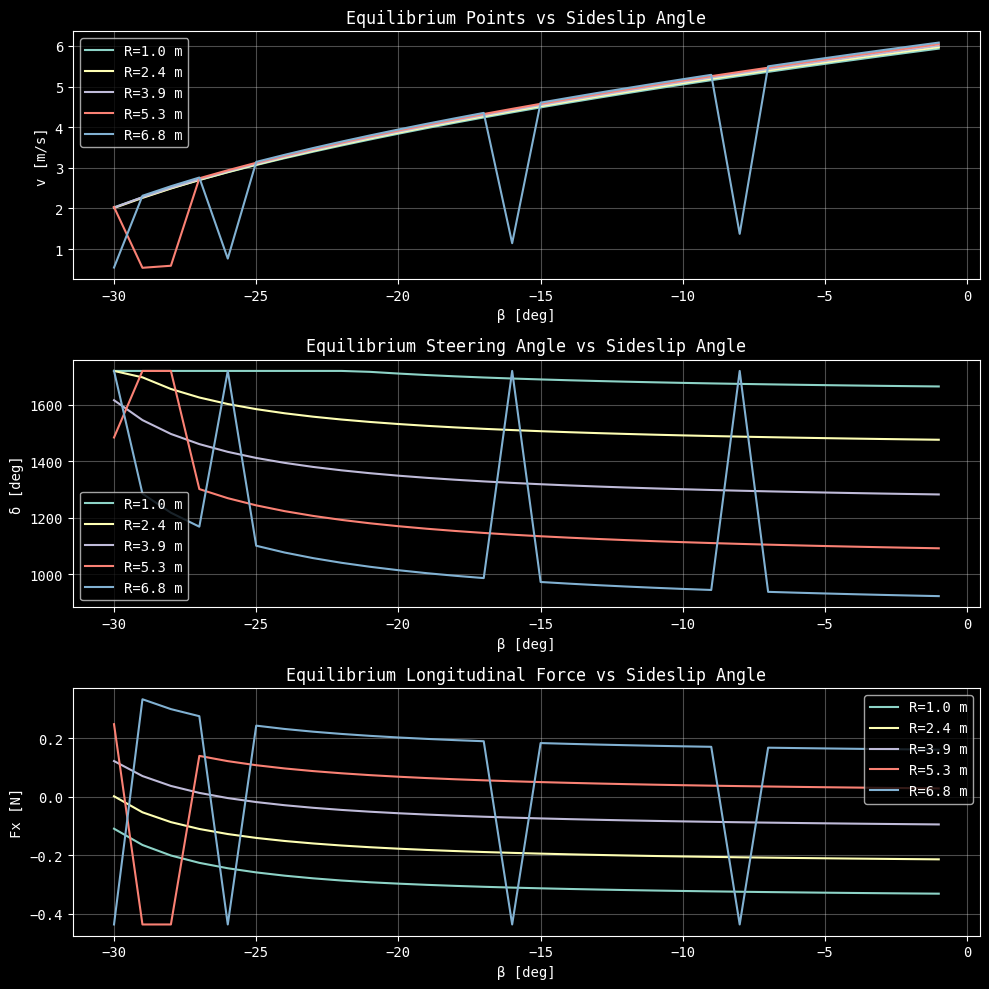

In [12]:
# plot some eq curves
plt.figure(figsize=(10, 10))
dec_r = int(n_grid / 5)  # decimation factor for the radii
xp, up, errp = map(lambda x: x.copy().reshape(n_grid, n_grid, -1), (gx, gu, gerr))  # decimate the equilibrium points and u inputs
vs, Fxs, δs = xp[:,::dec_r,0], up[:,::dec_r,0], up[:,::dec_r,1]  # unpack the equilibrium points and u inputs
radiip = radii[::dec_r]  # decimate the radii
plt.subplot(3,1,1)
for i, r in enumerate(radiip):  # iterate over the radii
    plt.plot(βs*180/π, vs[:,i], label=f'R={r:.1f} m')  # plot the equilibrium points
plt.xlabel('β [deg]'), plt.ylabel('v [m/s]'), plt.legend()
plt.title('Equilibrium Points vs Sideslip Angle')

plt.subplot(3,1,2)
for i, r in enumerate(radiip):  # iterate over the radii
    plt.plot(βs*180/π, δs[:,i]*180/π, label=f'R={r:.1f} m')  # plot the equilibrium points
plt.xlabel('β [deg]'), plt.ylabel('δ [deg]'), plt.legend()
plt.title('Equilibrium Steering Angle vs Sideslip Angle')   

plt.subplot(3,1,3)
for i, r in enumerate(radiip):  # iterate over the radii
    plt.plot(βs*180/π, Fxs[:,i], label=f'R={r:.1f} m')  # plot the equilibrium points
plt.xlabel('β [deg]'), plt.ylabel('Fx [N]'), plt.legend()
plt.title('Equilibrium Longitudinal Force vs Sideslip Angle')
plt.tight_layout()
plt.show()

In [13]:
# show some animations
for i in range(3):
    rand_idx = np.random.randint(0, n_grid**2)  # random index
    eq_x, eq_u = gx[rand_idx], gu[rand_idx]  # get the equilibrium point and u input

    # simulate the STM with the equilibrium point
    xs = sim_stm_fixed_u(
        vβr0=eq_x,  # use the equilibrium point as initial state
        δ=eq_u[0],  # use the solution for δ
        Fx=eq_u[1],  # use the solution for Fx
        sim_t=2,  # simulate for 2 seconds
        dt=DT,  # time step
    )  # run the simulation with the equilibrium point

    # car animation
    anim = car_anim( 
        xs=xs,  # use the state vector as input
        us=np.ones((xs.shape[0],2)) * eq_u, 
        ic=np.array([eq_x[0]/eq_x[2], 0, π/2-eq_x[1]]),  
        dt=DT, 
        fps=60, 
        speed=0.75,  
        follow=False,
        title=f'Eq: v={eq_x[0]:.2f} m/s, β={eq_x[1]*180/π:.2f} deg, r={eq_x[2]:.2f} rad/s, Fx={eq_u[0]:.2f} N, δ={eq_u[1]*180/π:.2f} deg, R={eq_x[0]/eq_x[2]:.2f} m'
    )  # run the car animation with the STM results
